In [1]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import numpy as np

In [3]:
os.chdir('logs_local')

In [4]:
df = pd.DataFrame(columns=['Run_time','Run_mode','Epochs','Nb_Worker','Batch_Size','Val_loss_time','Val_loss_value', 'Train_loss'])

In [5]:
df.head()

,Run_time,Run_mode,Epochs,Nb_Worker,Batch_Size,Val_loss_time,Val_loss_value,Train_loss


In [6]:
def parse_dict(x):
    times = []
    losses = []
    for element in x['losses_val']:
        for k,v in element.items():
            if k=='time':
                times.append(pd.to_datetime(v)) 
            else:
                losses.append(v) 
    losses = np.array(losses)
    times = np.array(times) 
    
    times = (times - times[0])
    times = [x.total_seconds() for x in times]
    return np.array(times), np.array(losses)


In [7]:
for file in os.listdir():
    if file.startswith("log"):
        with open(file) as f:
            x = json.load(f)[0]
            #print(x.keys())
            
            times,losses = parse_dict(x)
            dict_x = {'Run_time':pd.to_datetime(x['end_time'])-pd.to_datetime(x['start_time']),
                      'Run_mode':x['running_mode'],
                      'Epochs':int(x['sync_epochs']),
                      'Nb_Worker': int(x['n_workers']),
                      'Batch_Size':int(x['batch']),
                      'Val_loss_time':times,
                      'Val_loss_value':losses,
                      'Train_loss':x['losses_train']}
            df_x  = pd.DataFrame([dict_x], columns=dict_x.keys())
            df  = pd.concat([df_x, df], axis =0, ignore_index=True)

In [9]:
df.head()

,Run_time,Run_mode,Epochs,Nb_Worker,Batch_Size,Val_loss_time,Val_loss_value,Train_loss
0,00:01:32.477808,asynchronous,0,2,256,"[0.0, 0.03866, 0.119104, 0.19528, 0.238585, 0....","[0.9813737336094728, 0.9882126417248985, 0.963...","[{'worker_idx': 1, 'loss_train': 0.99516248703..."
1,00:09:31.591511,asynchronous,0,5,256,"[0.0, 0.039498, 0.435455, 0.521094, 0.825922, ...","[0.9985493194249929, 0.9964105353623808, 0.999...","[{'worker_idx': 2, 'loss_train': 1.00032567977..."
2,00:06:05.374150,asynchronous,0,1,256,"[0.0, 0.155883, 0.290516, 0.4099, 0.529042, 0....","[0.9811500387288213, 0.9736281534933382, 0.927...","[{'worker_idx': 0, 'loss_train': 0.99127697944..."
3,00:14:48.126343,asynchronous,0,10,256,"[0.0, 0.695564, 0.798025, 1.310374, 1.407675, ...","[0.9963057041462977, 0.9940285148076634, 0.992...","[{'worker_idx': 0, 'loss_train': 0.99753314256..."


In [15]:
def plot_local(df):
    data = df

    different_workers = data['Nb_Worker'].unique()
    different_workers = np.sort(different_workers)

    for i in range(len(different_workers)):
        data_single = data[data['Nb_Worker']==different_workers[i]]
        plt.plot(np.array(data_single['Val_loss_time'])[0],np.array(data_single['Val_loss_value'])[0],label=str(different_workers[i]))
        
    #plt.title(f"Validation loss vs Time for a Batch Size = {batch} for {mode} mode")
    plt.xlabel("Time")
    plt.ylabel("Validation loss")
    plt.legend(title='Workers')
    plt.show()

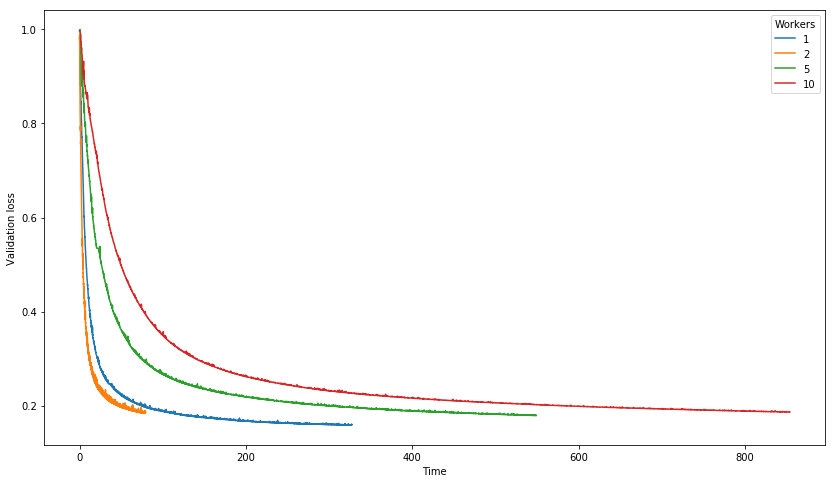

In [17]:
plt.figure(figsize=(14,8))
plot_local(df)

In [10]:
def plot_mode_val_vs_time_worker(df,mode,batch):
    data = df[(df['Run_mode']==mode) & (df['Batch_Size']==batch)]

    different_workers = data['Nb_Worker'].unique()
    different_workers = np.sort(different_workers)

    for i in range(len(different_workers)):
        data_single = data[data['Nb_Worker']==different_workers[i]]
        plt.plot(np.array(data_single['Val_loss_time'])[0],np.array(data_single['Val_loss_value'])[0],label=str(different_workers[i]))
        
    plt.title(f"Validation loss vs Time for a Batch Size = {batch} for {mode} mode")
    plt.xlabel("Time")
    plt.ylabel("Validation loss")
    plt.legend(title='Workers')
    plt.show()

In [ ]:
def plot_mode_batch_vs_time_worker(df,mode):
    data = df[(df['Run_mode']==mode)]
    
    different_workers = data['Nb_Worker'].unique()
    different_workers = np.sort(different_workers)

    for i in range(len(different_workers)):
        data_single = data[data['Nb_Worker']==different_workers[i]]
        plt.plot(data_single['Run_time'],data_single['Batch_Size'],label=str(different_workers[i]))
        
    plt.xlabel("Batch Size")
    plt.ylabel("Total Running time")
    plt.legend(title='Workers')
    plt.show()

In [ ]:
def plot_mode_val_vs_time_batch(df,mode,worker):
    data = df[(df['Run_mode']==mode) & (df['Nb_Worker']==worker)]
    
    different_batch = data['Batch_Size'].unique()
    different_batch = np.sort(different_batch)
    
    for i in range(len(different_batch)):
        data_single = data[data['Batch_Size']==different_batch[i]]
        plt.plot(np.array(data_single['Val_loss_time'])[0],np.array(data_single['Val_loss_value'])[0],label=str(different_batch[i]))
        
    plt.title(f"Validation loss vs Time with {worker} workers for {mode} mode")
    plt.xlabel("Time")
    plt.ylabel("Validation loss")
    plt.legend(title='Batch Sizes')

In [ ]:
plt.figure(figsize=(14,8)) 
plt.subplot(1,2,1)
plot_mode_val_vs_time_worker(df,"asynchronous",128)
plt.subplot(1,2,2)
plot_mode_val_vs_time_worker(df,"synchronous",128)

In [ ]:
plt.figure(figsize=(15,8)) 
plt.subplot(1,2,1)
plot_mode_val_vs_time_batch(df,"asynchronous",1)
plt.subplot(1,2,2)
plot_mode_val_vs_time_batch(df,"synchronous",1)

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plot_mode_val_vs_time_batch(df,"asynchronous",2)
plt.subplot(1,2,2)
plot_mode_val_vs_time_batch(df,"synchronous",2)

In [ ]:
plt.figure(figsize=(15,8)) 
plt.subplot(1,2,1)
plot_mode_val_vs_time_batch(df,"asynchronous",5)
plt.subplot(1,2,2)
plot_mode_val_vs_time_batch(df,"synchronous",5)

In [ ]:
plt.figure(figsize=(15,8)) 
plt.subplot(1,2,1)
plot_mode_val_vs_time_batch(df,"asynchronous",10)
plt.subplot(1,2,2)
plot_mode_val_vs_time_batch(df,"synchronous",10)

In [ ]:
plt.figure(figsize=(15,8)) 
plt.subplot(1,2,1)
plot_mode_val_vs_time_batch(df,"asynchronous",20)
plt.subplot(1,2,2)
plot_mode_val_vs_time_batch(df,"synchronous",20)